In [1]:
#Libraries
%matplotlib inline
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)
from tensorflow.keras import models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Flatten, BatchNormalization, Conv2D, MaxPooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, CSVLogger
from tensorflow.keras.callbacks import TensorBoard
import datetime
%load_ext tensorboard
from PIL import Image
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, classification_report
import itertools
import os
import shutil
import random
import glob
import matplotlib.pyplot as plt
import warnings

import os
os.environ['PYTHONHASHSEED'] = '0'

np.random.seed(37)
random.seed(1254)
tf.random.set_seed(89)

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]=""  # specify which GPU(s) to be used

print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

warnings.simplefilter(action='ignore', category=FutureWarning)
%matplotlib inline


#Metrics
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))


#Plot Confussion Matrix Function
def plot_confusion_matrix(cm, classes,
                        normalize=False,
                        title='Confusion matrix',
                        cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Num GPUs Available:  1


# Transfer Learning Models Comparison

In [2]:
os.chdir(r'C:\Users\panoc\Documents\thesis\Python\Models History')

InceptionResNetV2_RCM = pd.read_csv('history_InceptionResNetV2_RCM_TEST.log')
MobileNet_RCM = pd.read_csv('history_MobileNet_RCM_48M.log')
NasNetLarge_RCM = pd.read_csv('history_NasNetLarge_RCM_TEST.log')
ResNet50_RCM = pd.read_csv('history_ResNet50_RCM_53M.log')
ResNet152V2_RCM = pd.read_csv('history_ResNet152V2_RCM_TEST.log')
VGG16_RCM = pd.read_csv('history_VGG16_RCM_4M.log')

In [3]:
# InceptionResNetV2
METRICS = InceptionResNetV2_RCM.drop(['accuracy', 'f1_m', 'loss', 'precision_m', 'recall_m', 'val_f1_m', 'val_precision_m', 'val_recall_m'], axis=1)
METRICS = METRICS.rename(columns={"val_accuracy": "InceptionResNetV2_acc", "val_loss": "InceptionResNetV2_loss"})

# MobileNet
TEMP = MobileNet_RCM.drop(['epoch', 'accuracy', 'f1_m', 'loss', 'precision_m', 'recall_m', 'val_f1_m', 'val_precision_m', 'val_recall_m'], axis=1)
TEMP = TEMP.rename(columns={"val_accuracy": "MobileNet_acc", "val_loss": "MobileNet_loss"})
METRICS = METRICS.join(TEMP)

# NasNetLarge
TEMP = NasNetLarge_RCM.drop(['epoch', 'accuracy', 'f1_m', 'loss', 'precision_m', 'recall_m', 'val_f1_m', 'val_precision_m', 'val_recall_m'], axis=1)
TEMP = TEMP.rename(columns={"val_accuracy": "NasNetLarge_acc", "val_loss": "NasNetLarge_loss"})
METRICS = METRICS.join(TEMP)

# ResNet50
TEMP = ResNet50_RCM.drop(['epoch', 'accuracy', 'f1_m', 'loss', 'precision_m', 'recall_m', 'val_f1_m', 'val_precision_m', 'val_recall_m'], axis=1)
TEMP = TEMP.rename(columns={"val_accuracy": "ResNet50_acc", "val_loss": "ResNet50_loss"})
METRICS = METRICS.join(TEMP)

# ResNet152V2
TEMP = ResNet152V2_RCM.drop(['epoch', 'accuracy', 'f1_m', 'loss', 'precision_m', 'recall_m', 'val_f1_m', 'val_precision_m', 'val_recall_m'], axis=1)
TEMP = TEMP.rename(columns={"val_accuracy": "ResNet152V2_acc", "val_loss": "ResNet152V2_loss"})
METRICS = METRICS.join(TEMP)

# VGG16
TEMP = VGG16_RCM.drop(['epoch', 'accuracy', 'f1_m', 'loss', 'precision_m', 'recall_m', 'val_f1_m', 'val_precision_m', 'val_recall_m'], axis=1)
TEMP = TEMP.rename(columns={"val_accuracy": "VGG16_acc", "val_loss": "VGG16_loss"})
METRICS = METRICS.join(TEMP)

In [4]:
METRICS.head(2)

,epoch,InceptionResNetV2_acc,InceptionResNetV2_loss,MobileNet_acc,MobileNet_loss,NasNetLarge_acc,NasNetLarge_loss,ResNet50_acc,ResNet50_loss,ResNet152V2_acc,ResNet152V2_loss,VGG16_acc,VGG16_loss
0,0,0.450,3.690798,0.750,0.582939,0.400,0.798097,0.625,0.982140,0.5,109.000206,0.625,0.756674
1,1,0.475,4.764773,0.725,0.582889,0.375,0.800094,0.625,0.909944,0.5,134.560379,0.650,0.660539


In [5]:
METRICS.loc[METRICS['InceptionResNetV2_loss'] > 1, 'InceptionResNetV2_loss'] = 1
METRICS.loc[METRICS['ResNet152V2_loss'] > 1, 'ResNet152V2_loss'] = 1

# METRICS.head(2)

In [6]:
print('InceptionResNetV2_loss: ' + str(METRICS['InceptionResNetV2_loss'].mean()*100))
print('MobileNet_loss: ' + str(METRICS['MobileNet_loss'].mean()))
print('NasNetLarge_loss: ' + str(METRICS['NasNetLarge_loss'].mean()))
print('ResNet50_loss: ' + str(METRICS['ResNet50_loss'].mean()))
print('ResNet152V2_loss: ' + str(METRICS['ResNet152V2_loss'].mean()))
print('VGG16_loss: ' + str(METRICS['VGG16_loss'].mean()))
print()
print('InceptionResNetV2_acc: ' + str(METRICS['InceptionResNetV2_acc'].mean()))
print('MobileNet_acc: ' + str(METRICS['MobileNet_acc'].mean()))
print('NasNetLarge_acc: ' + str(METRICS['NasNetLarge_acc'].mean()))
print('ResNet50_acc: ' + str(METRICS['ResNet50_acc'].mean()))
print('ResNet152V2_acc: ' + str(METRICS['ResNet152V2_acc'].mean()))
print('VGG16_acc: ' + str(METRICS['VGG16_acc'].mean()))

InceptionResNetV2_loss: 100.0
MobileNet_loss: 0.5919761300086975
NasNetLarge_loss: 0.8392315591375034
ResNet50_loss: 0.7138195584217707
ResNet152V2_loss: 1.0
VGG16_loss: 0.5265565890073777

InceptionResNetV2_acc: 0.5033333333333333
MobileNet_acc: 0.7175
NasNetLarge_acc: 0.3666666666666666
ResNet50_acc: 0.6795833333333335
ResNet152V2_acc: 0.5
VGG16_acc: 0.7805


Text(0, 0.5, 'Percentage')

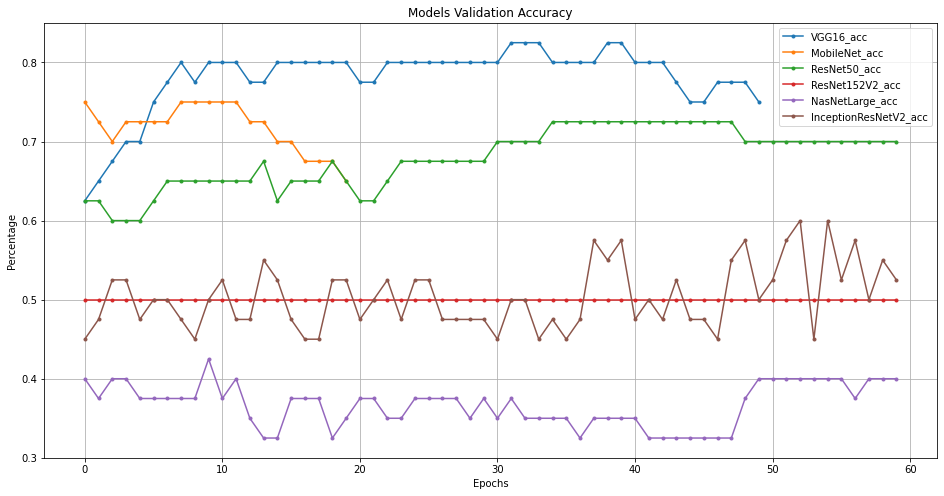

In [7]:
acc_graph = METRICS.plot(x='epoch', 
             y=['VGG16_acc',
                'MobileNet_acc',
                'ResNet50_acc', 
                'ResNet152V2_acc',
                'NasNetLarge_acc',
                'InceptionResNetV2_acc',],   
             title = 'Models Validation Accuracy',
             figsize=(16,8),
             grid = True,
             style='.-'
            
            )

acc_graph.set_xlabel("Epochs")
acc_graph.set_ylabel("Percentage")

Text(0, 0.5, 'percentage')

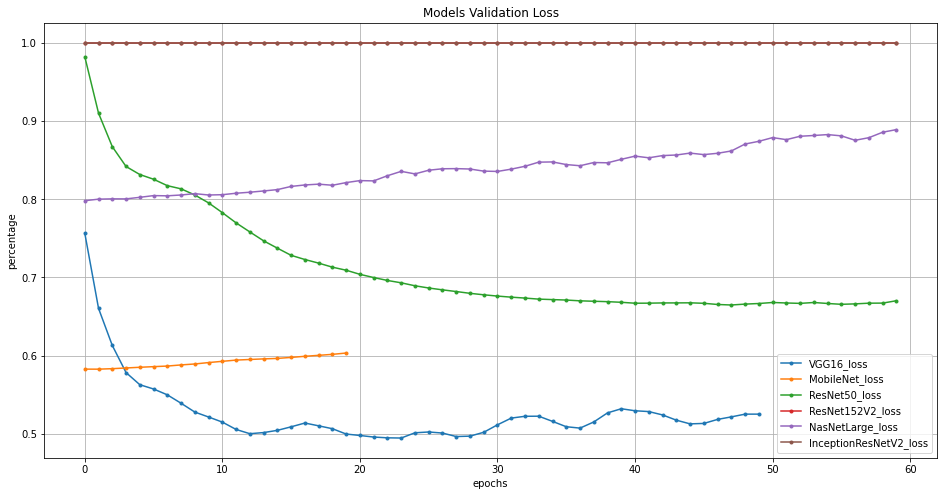

In [8]:
loss_graph = METRICS.plot(x='epoch', 
             y=['VGG16_loss',
                'MobileNet_loss',
                'ResNet50_loss', 
                'ResNet152V2_loss',
                'NasNetLarge_loss',
                'InceptionResNetV2_loss'],      
             title = 'Models Validation Loss',
             figsize=(16,8),
             grid = True,
             style='.-'
            
            )

loss_graph.set_xlabel("epochs")
loss_graph.set_ylabel("percentage")

# VGG16 vs Custom CNN

In [2]:
dependencies = {
    'recall_m': recall_m,
    'precision_m': precision_m,
    'f1_m': f1_m
}

model = tf.keras.models.load_model(r'C:\Users\panoc\Documents\thesis\Python\Models\Model_33M.h5', custom_objects=dependencies)
vgg16 = tf.keras.models.load_model(r'C:\Users\panoc\Documents\thesis\Python\Models\VGG16_RCM_model_4M.h5', custom_objects=dependencies)

In [4]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 270, 270, 32)      2432      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 266, 266, 32)      25632     
_________________________________________________________________
activation (Activation)      (None, 266, 266, 32)      0         
_________________________________________________________________
dropout (Dropout)            (None, 266, 266, 32)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 133, 133, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 131, 131, 64)      18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 129, 129, 64)      3

In [10]:
os.chdir(r'C:\Users\panoc\Documents\thesis\dataset')

train_path = r'train'
valid_path = r'valid'
test_path = r'test'

SIZE = 272
BATCH_SIZE = 20

model_test_batches = ImageDataGenerator() \
    .flow_from_directory(directory=test_path, target_size=(SIZE,SIZE), classes=['BENIGN', 'MALIGNANT'], batch_size=BATCH_SIZE, shuffle=False)


os.chdir(r'C:\Users\panoc\Documents\thesis\dataset')

train_path = r'train'
valid_path = r'valid'
test_path = r'test'

SIZE = 224
BATCH_SIZE = 70

vgg16_test_batches = ImageDataGenerator() \
    .flow_from_directory(directory=test_path, target_size=(SIZE,SIZE), classes=['BENIGN', 'MALIGNANT'], batch_size=BATCH_SIZE, shuffle=False)

Found 40 images belonging to 2 classes.
Found 40 images belonging to 2 classes.


Confusion matrix, without normalization
[[26  4]
 [ 0 10]]
              precision    recall  f1-score   support

      Benign       1.00      0.87      0.93        30
   Malignant       0.71      1.00      0.83        10

    accuracy                           0.90        40
   macro avg       0.86      0.93      0.88        40
weighted avg       0.93      0.90      0.90        40



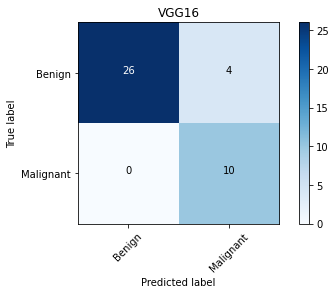

In [11]:
vgg16_predictions = vgg16.predict(x=vgg16_test_batches, steps=len(vgg16_test_batches), verbose=0)

# print(np.argmax(predictions, axis=-1))

imgs, labels = next(vgg16_test_batches)
# print(np.argmax(labels, axis=-1))

cm = confusion_matrix(y_true=vgg16_test_batches.classes, y_pred=np.argmax(vgg16_predictions, axis=-1))
cm_plot_labels = ['Benign','Malignant']
plot_confusion_matrix(title = 'VGG16', cm=cm, classes=cm_plot_labels)

print(classification_report(y_true=vgg16_test_batches.classes, y_pred= np.argmax(vgg16_predictions, axis=-1), target_names = ['Benign','Malignant']))

Confusion matrix, without normalization
[[27  3]
 [ 3  7]]
              precision    recall  f1-score   support

      Benign       0.90      0.90      0.90        30
   Malignant       0.70      0.70      0.70        10

    accuracy                           0.85        40
   macro avg       0.80      0.80      0.80        40
weighted avg       0.85      0.85      0.85        40



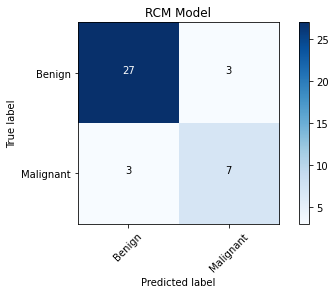

In [12]:
model_predictions = model.predict(x=model_test_batches, steps=len(model_test_batches), verbose=0)

# print(np.argmax(predictions, axis=-1))

imgs, labels = next(model_test_batches)
# print(np.argmax(labels, axis=-1))

cm = confusion_matrix(y_true=model_test_batches.classes, y_pred=np.argmax(model_predictions, axis=-1))
cm_plot_labels = ['Benign','Malignant']
plot_confusion_matrix(title = 'RCM Model', cm=cm, classes=cm_plot_labels)

print(classification_report(y_true=model_test_batches.classes, y_pred= np.argmax(model_predictions, axis=-1), target_names = ['Benign','Malignant']))

In [19]:
os.chdir(r'C:\Users\panoc\Documents\thesis\Python\Models History')

model_h = pd.read_csv('history_Model_33M.log')
vgg16_h = pd.read_csv('history_VGG16_RCM_4M.log')

print('VGG16 Loss: ' + str(vgg16_h['val_loss'].mean()))
print('CNN Loss: ' + str(model_h['val_loss'].mean()))
print()
print('VGG16 Acc: ' + str(vgg16_h['val_accuracy'].mean()))
print('CNN Acc: ' + str(model_h['val_accuracy'].mean()))

VGG16 Loss: 0.5265565890073777
CNN Loss: 0.6435295725862186

VGG16 Acc: 0.7805
CNN Acc: 0.6554166666666668


In [14]:
# My Model
FINAL_METRICS = model_h.drop(['accuracy', 'f1_m', 'loss', 'precision_m', 'recall_m'], axis=1)
FINAL_METRICS = FINAL_METRICS.rename(columns={"val_accuracy": "RCM_Model_acc", 
                                  "val_loss": "RCM_Model_loss",
                                  "val_precision_m": "RCM_Model_precision", 
                                  "val_recall_m": "RCM_recall",
                                  "val_f1_m": "RCM_Model_f1"
                                 })

# VGG16
TEMP2 = vgg16_h.drop(['epoch', 'accuracy', 'f1_m', 'loss', 'precision_m', 'recall_m'], axis=1)
TEMP2 = TEMP2.rename(columns={"val_accuracy": "VGG16_acc", 
                                  "val_loss": "VGG16_loss",
                                  "val_precision_m": "VGG16_precision", 
                                  "val_recall_m": "VGG16_recall",
                                  "val_f1_m": "VGG16_f1"
                                 })
FINAL_METRICS = FINAL_METRICS.join(TEMP2)

In [15]:
FINAL_METRICS.head(2)

,epoch,RCM_Model_acc,RCM_Model_f1,RCM_Model_loss,RCM_Model_precision,RCM_recall,VGG16_acc,VGG16_f1,VGG16_loss,VGG16_precision,VGG16_recall
0,0,0.55,0.666667,0.692208,0.5,1.0,0.625,0.625,0.756674,0.625,0.625
1,1,0.50,0.666667,0.691015,0.5,1.0,0.650,0.650,0.660539,0.650,0.650


Text(0, 0.5, 'Percentage')

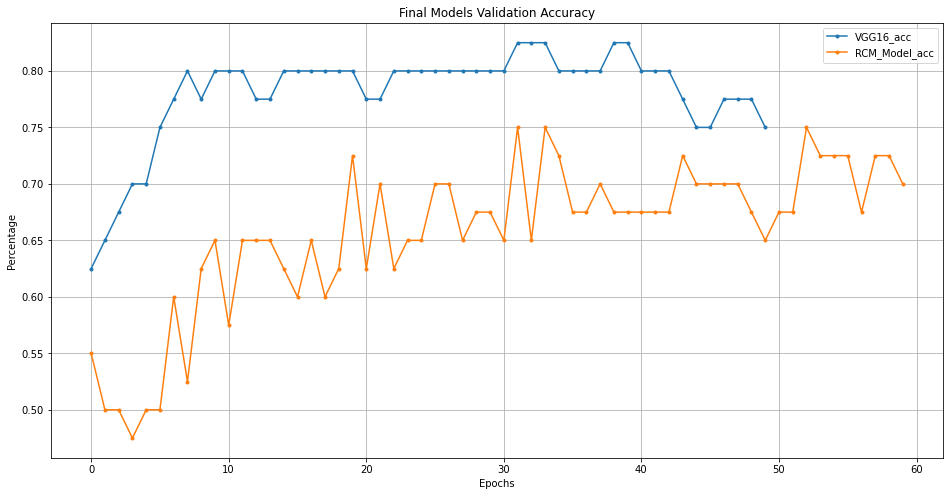

In [16]:
final_acc_graph = FINAL_METRICS.plot(x='epoch', 
             y=['VGG16_acc',
                'RCM_Model_acc'
                ],   
             title = 'Final Models Validation Accuracy',
             figsize=(16,8),
             grid = True,
             style='.-'
            
            )

final_acc_graph.set_xlabel("Epochs")
final_acc_graph.set_ylabel("Percentage")

Text(0, 0.5, 'Percentage')

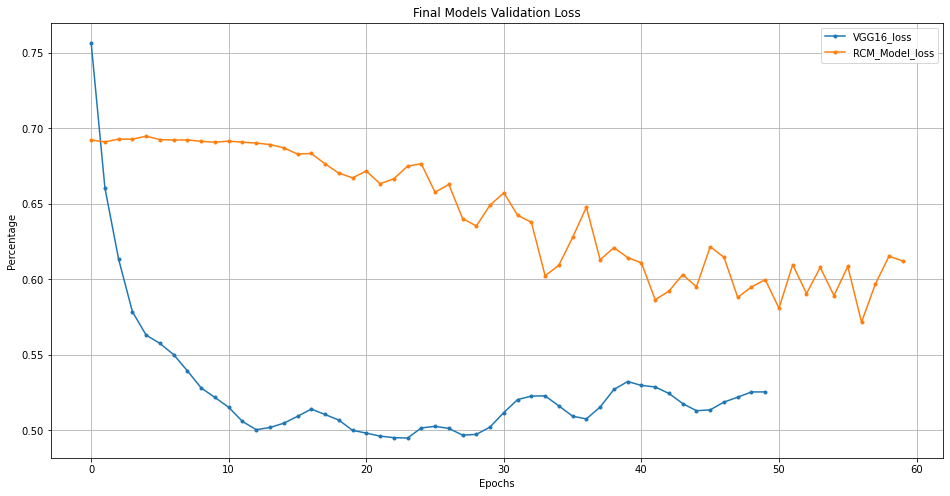

In [17]:
final_loss_graph = FINAL_METRICS.plot(x='epoch', 
             y=['VGG16_loss',
                'RCM_Model_loss'
                ],   
             title = 'Final Models Validation Loss',
             figsize=(16,8),
             grid = True,
             style='.-'
            
            )

final_loss_graph.set_xlabel("Epochs")
final_loss_graph.set_ylabel("Percentage")

In [18]:
# VGG16_RCM['val_loss'].mean()